In [1]:
from asammdf import MDF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
mdf = MDF(r"D:\工作\2020\5月\压降 dat\MTB-309_SummerTest_Brk_48.4%_38℃_2019-08-12_01.dat")

In [3]:
mdf.version

'3.00'

In [4]:
mdf.channels_db

{'time': [(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (6, 0),
  (7, 0),
  (8, 0),
  (9, 0),
  (10, 0),
  (11, 0),
  (12, 0),
  (13, 0),
  (14, 0),
  (15, 0),
  (16, 0),
  (17, 0),
  (18, 0),
  (19, 0),
  (20, 0),
  (21, 0),
  (22, 0),
  (23, 0),
  (24, 0),
  (25, 0),
  (26, 0),
  (27, 0),
  (28, 0),
  (29, 0),
  (30, 0),
  (31, 0),
  (32, 0),
  (33, 0),
  (34, 0),
  (35, 0),
  (36, 0),
  (37, 0),
  (38, 0),
  (39, 0),
  (40, 0),
  (41, 0),
  (42, 0),
  (43, 0),
  (44, 0),
  (45, 0),
  (46, 0),
  (47, 0),
  (48, 0),
  (49, 0),
  (50, 0),
  (51, 0),
  (52, 0),
  (53, 0),
  (54, 0),
  (55, 0),
  (56, 0),
  (57, 0),
  (58, 0),
  (59, 0),
  (60, 0),
  (61, 0),
  (62, 0),
  (63, 0),
  (64, 0),
  (65, 0),
  (66, 0),
  (67, 0),
  (68, 0),
  (69, 0),
  (70, 0),
  (71, 0),
  (72, 0),
  (73, 0),
  (74, 0),
  (75, 0),
  (76, 0),
  (77, 0),
  (78, 0),
  (79, 0),
  (80, 0),
  (81, 0),
  (82, 0),
  (83, 0),
  (84, 0),
  (85, 0),
  (86, 0),
  (87, 0),
  (88, 0),
  (89, 0),
  (90, 0),
 

In [ ]:
df = mdf.to_dataframe()

In [ ]:
df

# 2. 获取相关的数据

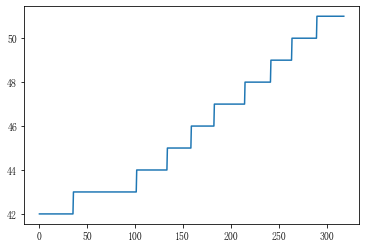

In [5]:
Temp_Cooling_EM_IN = mdf.get("EM_Temperatur_Rotor")
plt.plot(Temp_Cooling_EM_IN.timestamps, Temp_Cooling_EM_IN.samples)

In [59]:
Temp_Cooling_EM_IN.timestamps[2] - Temp_Cooling_EM_IN.timestamps[1]

0.010000116424635053

In [55]:
dif_pressure = mdf.get('DIF')
out_pressure = mdf.get('OUT')
in_pressure = mdf.get('IN')
flow_rate = mdf.get('FLOW')
set_flow_rate = mdf.get('SO_Flow_Rate_Cooling_EM\\SVW_CAN')
test_bench_flow = mdf.get('Flow_Rate_Cooling_EM')
test_bench_pressure_diff = mdf.get('Pressure_Drop_Cooling_EM')

In [58]:
dif_pressure.timestamps[2] - dif_pressure.timestamps[1]

0.010000116424635053

In [47]:
length = min(len(flow_rate.samples),len(out_pressure.samples))

In [48]:
sensor = pd.DataFrame()
sensor['time'] = dif_pressure.timestamps[:length]
sensor['dif_pressure'] = dif_pressure.samples[:length]
sensor['in_pressure'] = in_pressure.samples[:length]
sensor['out_pressure'] = out_pressure.samples[:length]
sensor['flow_rate'] = flow_rate.samples[:length]

In [49]:
test_bench = pd.DataFrame()
test_bench['time'] = set_flow_rate.timestamps
test_bench['set_flow_rate'] = set_flow_rate.samples

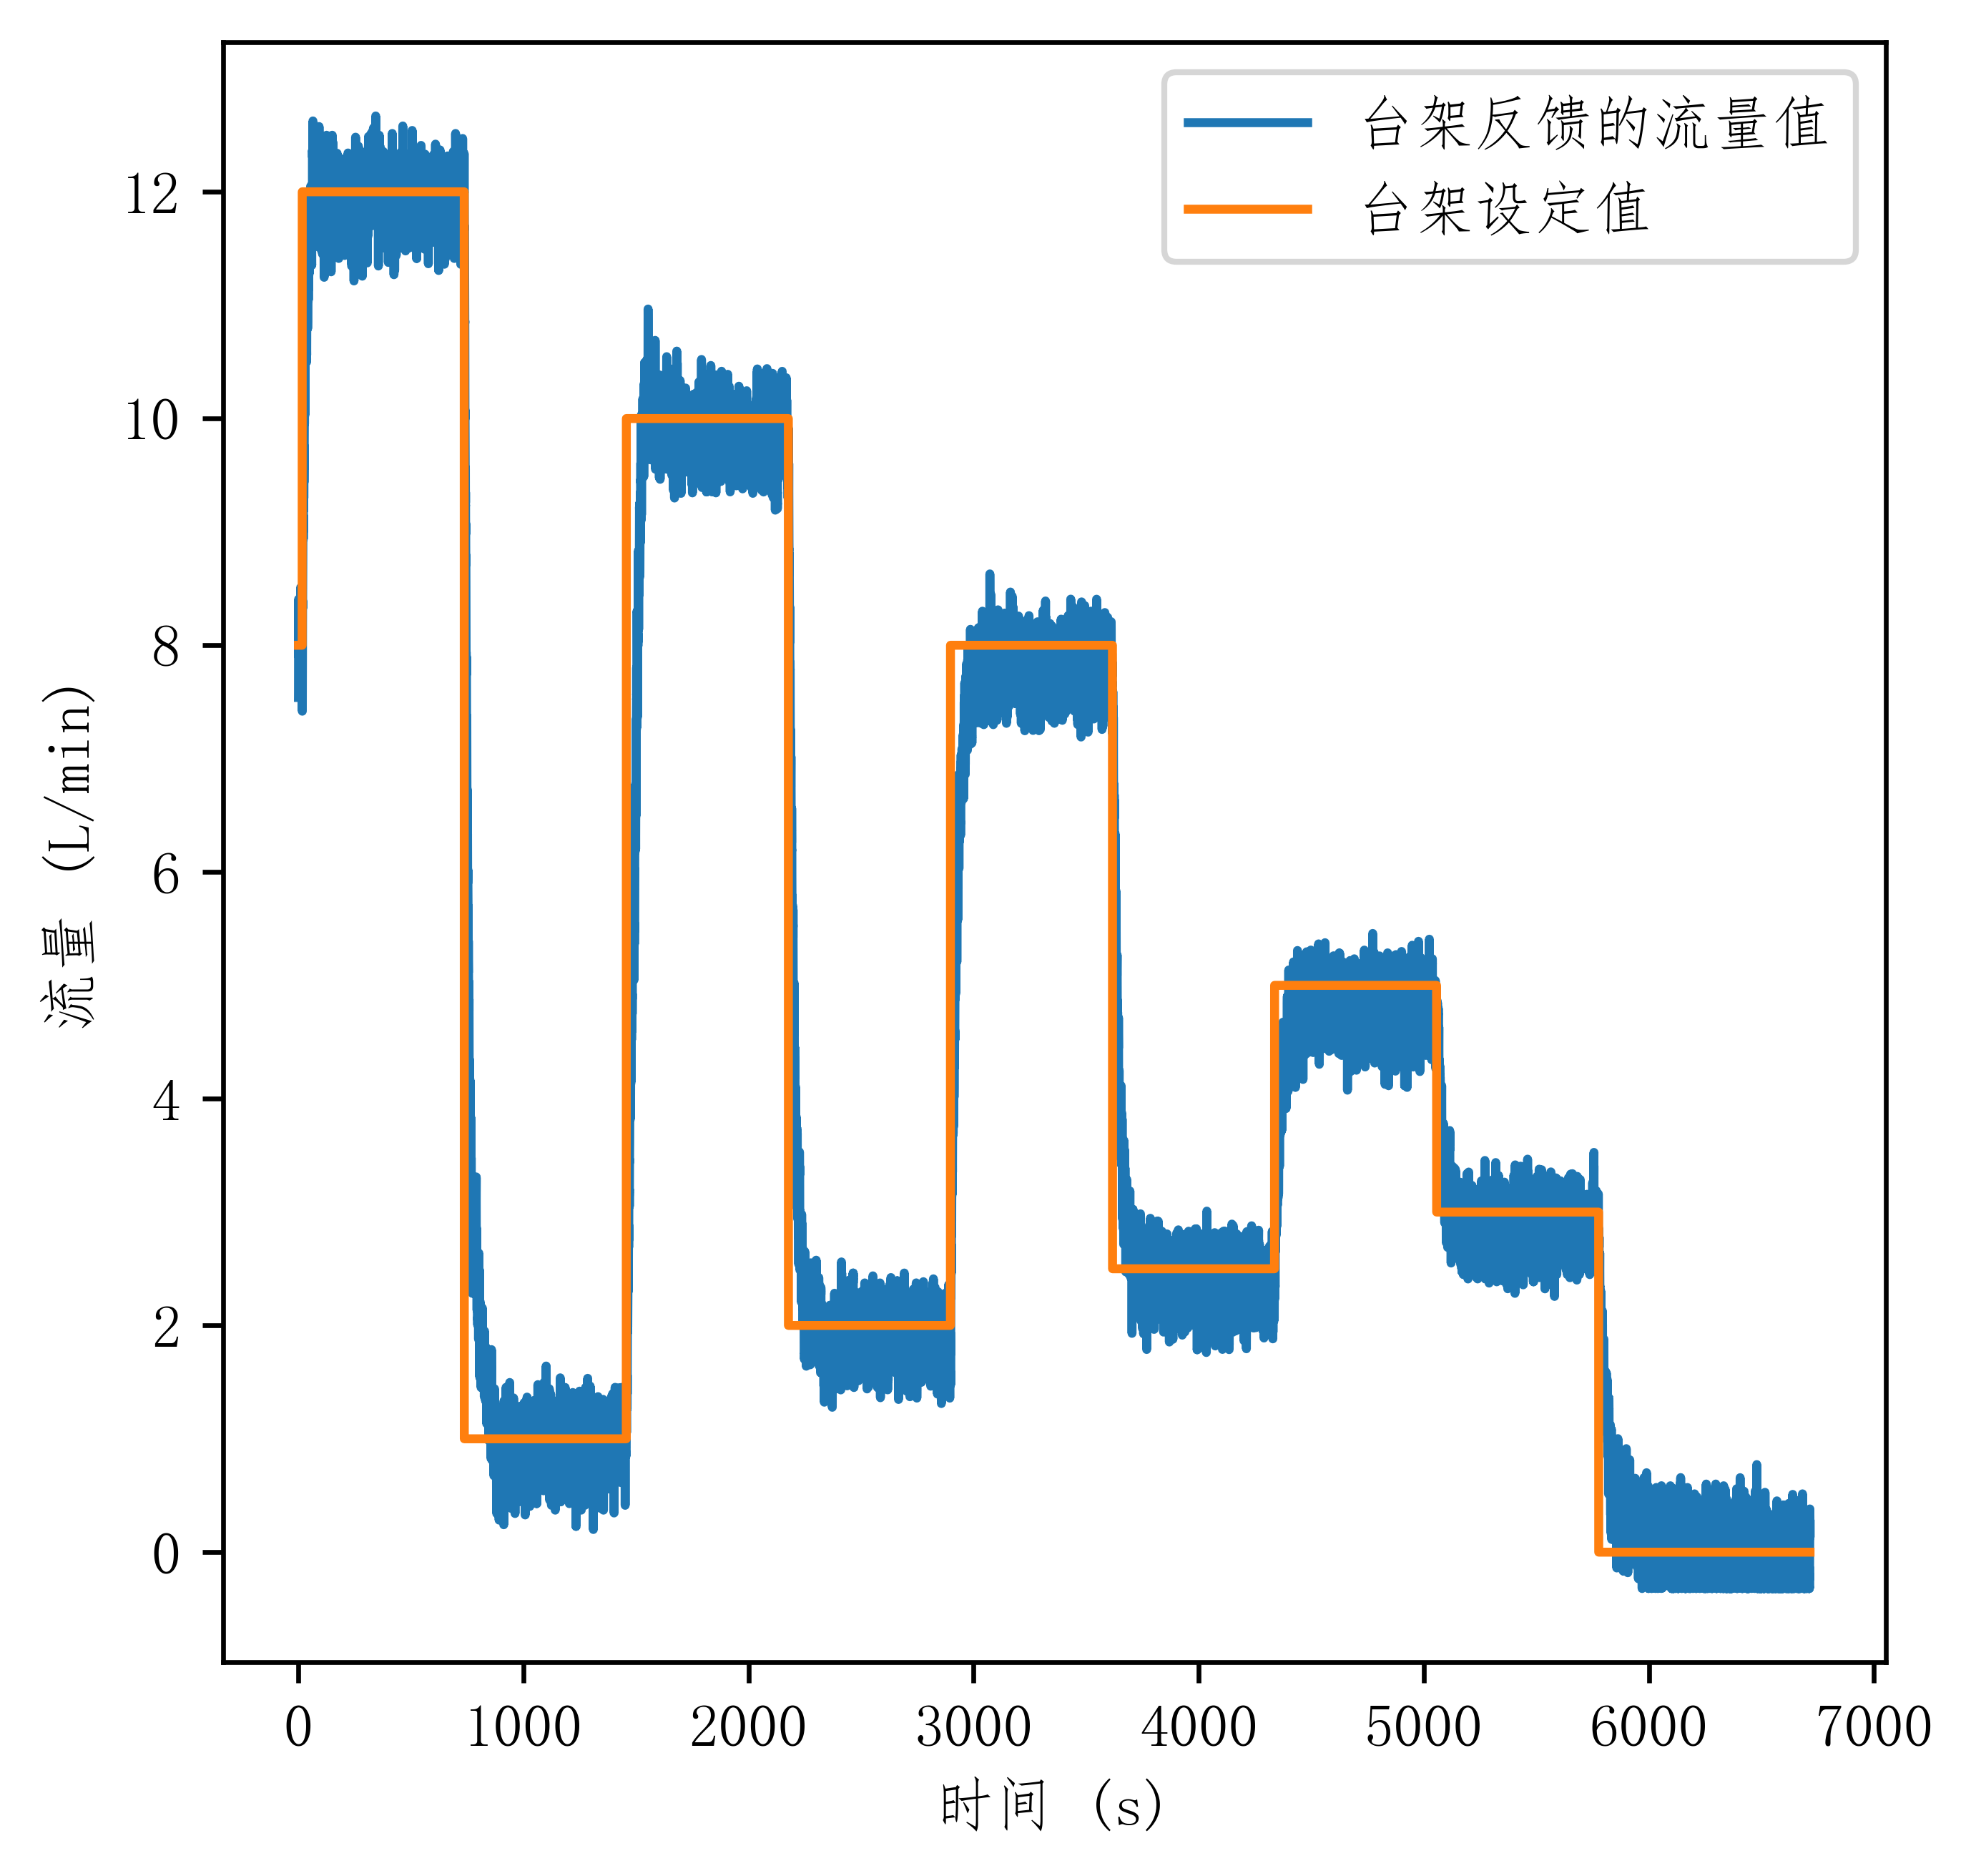

In [50]:
fig = plt.figure(figsize=(5,5), dpi=600)
ax = fig.add_subplot(1,1,1)
line1, = ax.plot(flow_rate.timestamps, flow_rate.samples)
line2, = ax.plot(set_flow_rate.timestamps, set_flow_rate.samples)
ax.set_xlabel('时间 (s)')
ax.set_ylabel('流量 (L/min)')
ax.legend([line1, line2], ['台架反馈的流量值', '台架设定值'])

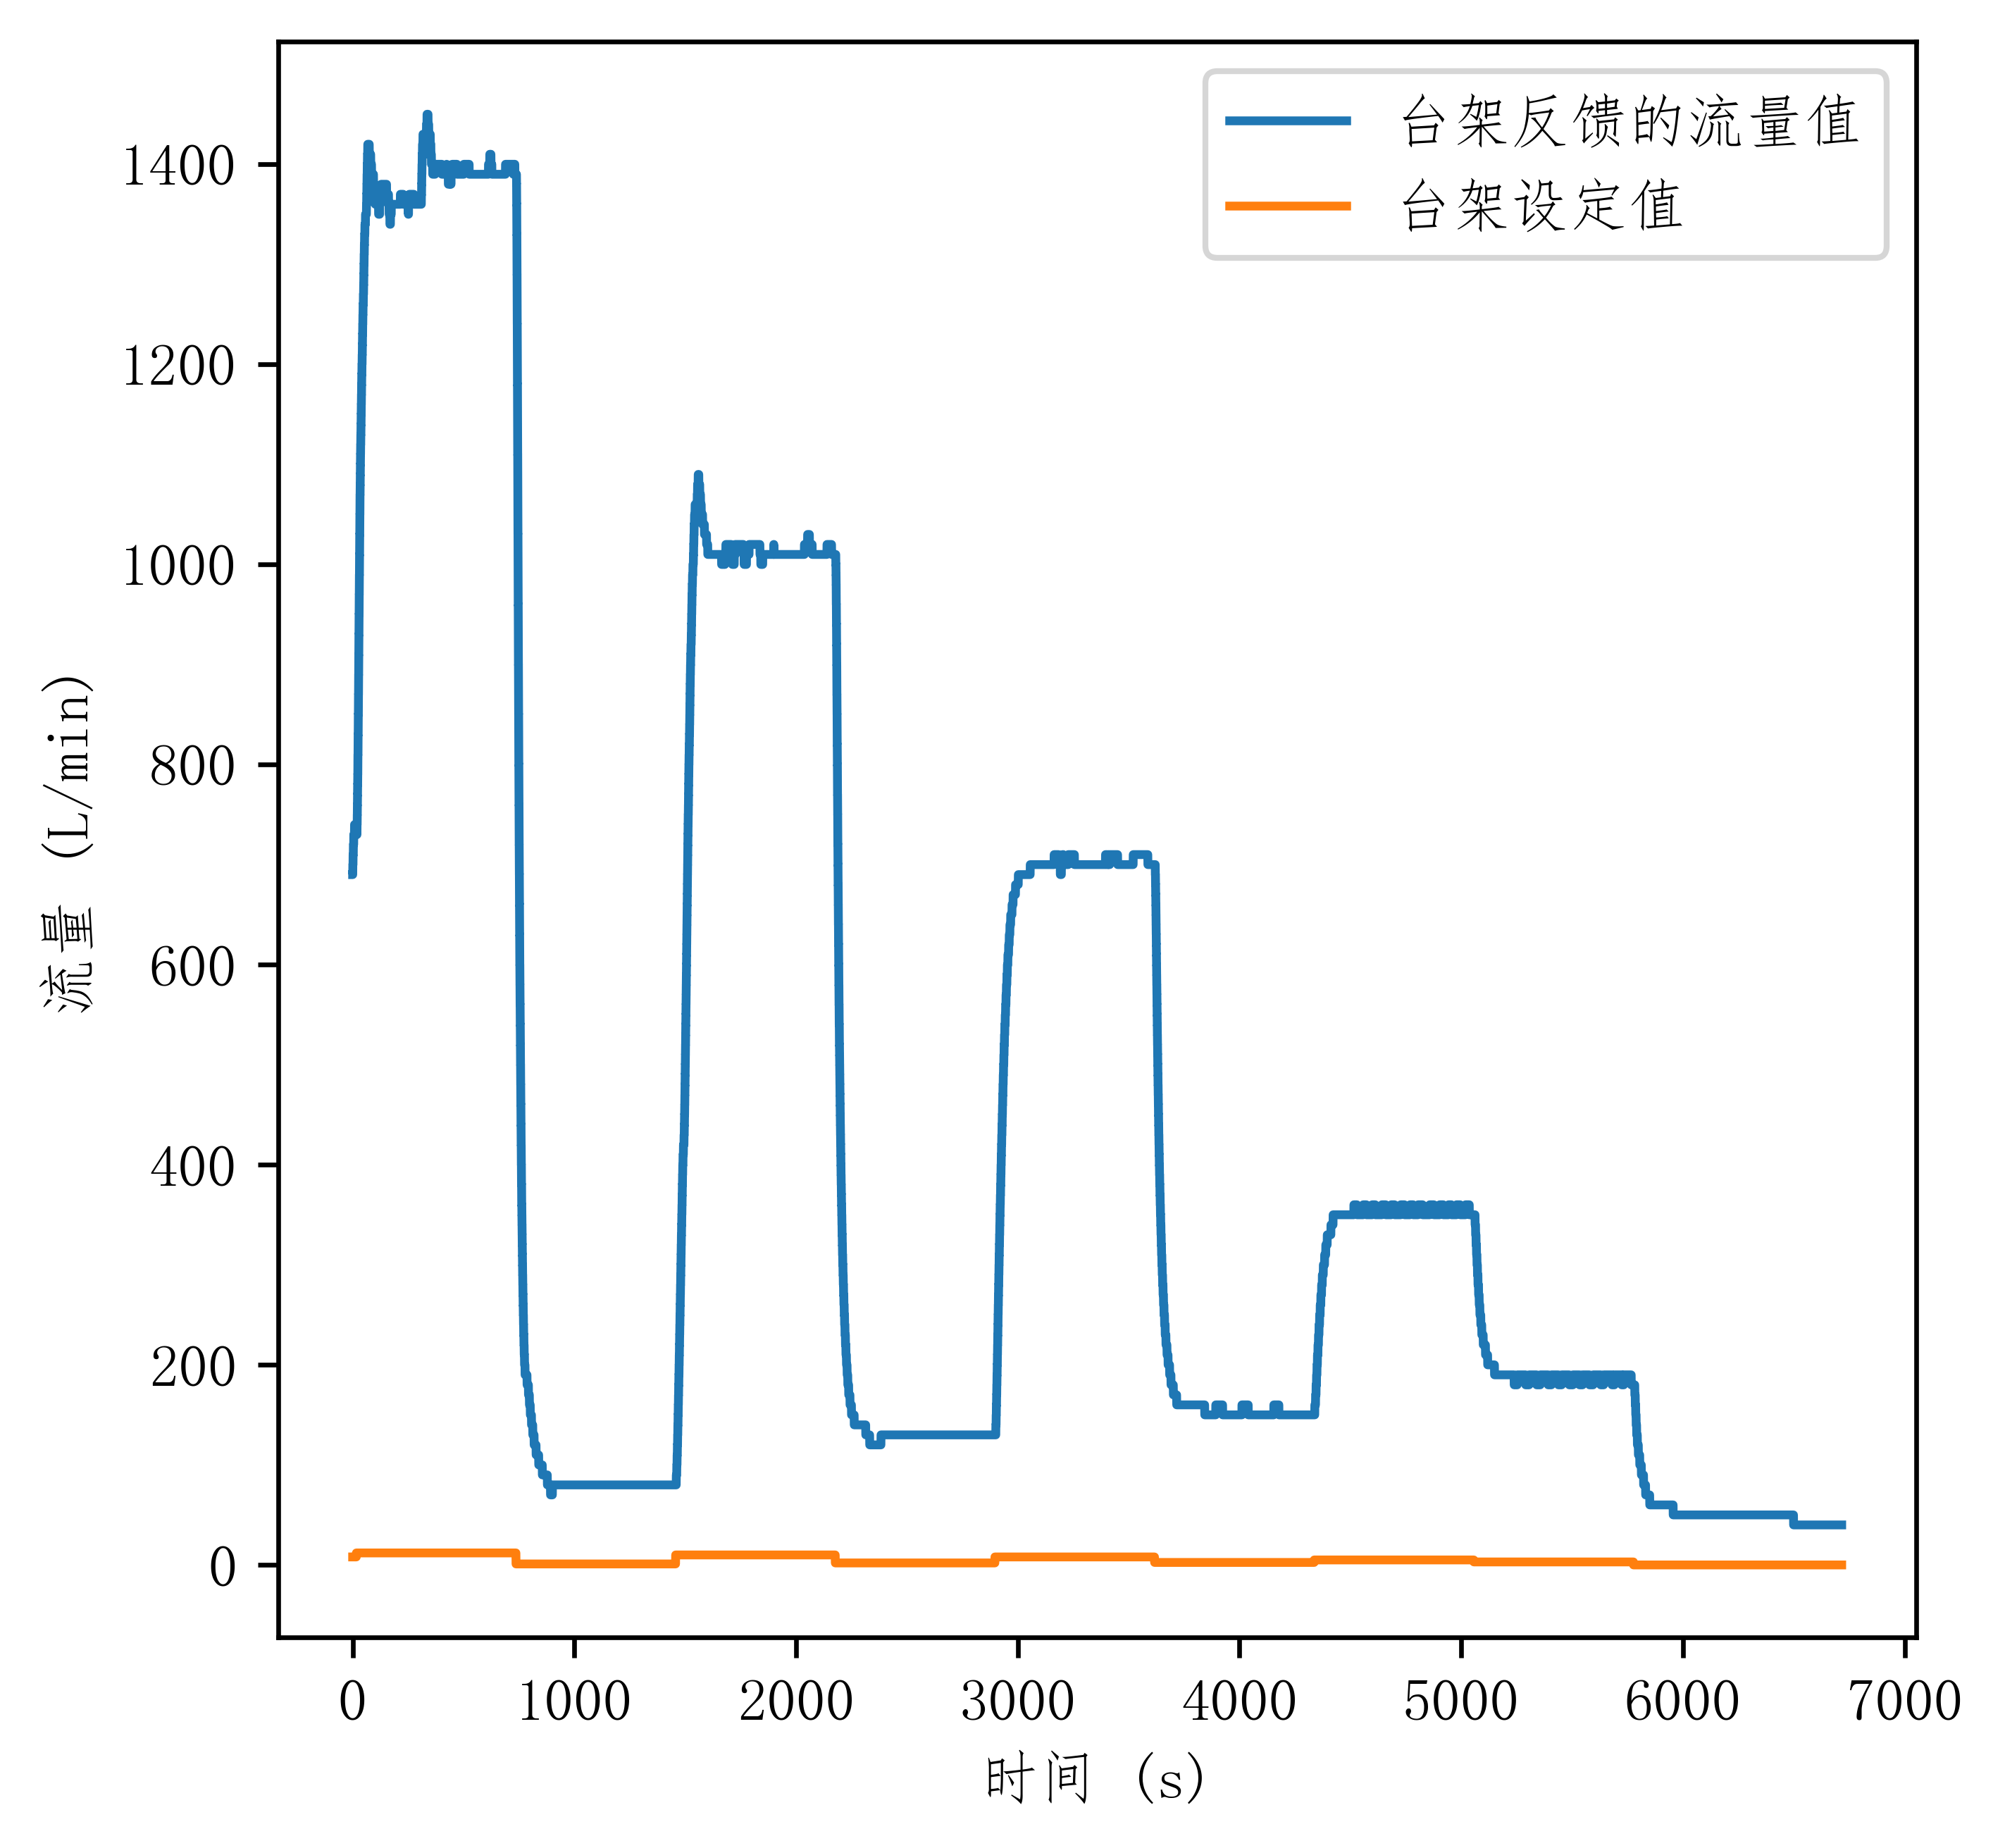

In [33]:
fig = plt.figure(figsize=(5,5), dpi=600)
ax = fig.add_subplot(1,1,1)
line1, = ax.plot(test_bench_pressure_diff.timestamps, test_bench_pressure_diff.samples)
line2, = ax.plot(set_flow_rate.timestamps, set_flow_rate.samples)
ax.set_xlabel('时间 (s)')
ax.set_ylabel('流量 (L/min)')
ax.legend([line1, line2], ['台架反馈的流量值', '台架设定值'])

In [34]:
grouped = test_bench.groupby("set_flow_rate")
last_flow_rate = test_bench.iloc[-1]['set_flow_rate']
first_flow_rate = test_bench.iloc[0]['set_flow_rate']

# 3. 确定各个工况的结束时间点

In [35]:
end_time = {}
times = []
group_time = {}
for name, group in grouped:
    group_time[name] = np.array(group['time'])
    end_time[name] = group_time[name][-1] - 1
    if name not in [first_flow_rate, last_flow_rate]:
        times.append(group_time[name][-1] - group_time[name][0])

In [36]:
end_time[last_flow_rate] =  group_time[last_flow_rate][0] + np.mean(times) - 1

# 4. 提取相关数据

In [37]:
result = pd.DataFrame()
for key in end_time.keys():
    foo = sensor[np.logical_and(sensor['time'] > end_time[key] - 60, sensor['time'] < end_time[key]) ]
    res = {'set_flow_rate [L/min]': key,
            'in_pressure [mbar]': foo['in_pressure'].mean(),
            'out_pressure [mbar]': foo['out_pressure'].mean(),
            'dif_pressure [mbar]': foo['dif_pressure'].mean(),
            'flow_rate [L/min]': foo['flow_rate'].mean()}
    result = result.append(res, ignore_index=True)
result = result[['set_flow_rate [L/min]','flow_rate [L/min]', 'dif_pressure [mbar]', 'out_pressure [mbar]', 'in_pressure [mbar]', ]]

In [38]:
result.to_excel('result.xlsx',sheet_name='test2', index=False)

In [39]:
result

,set_flow_rate [L/min],flow_rate [L/min],dif_pressure [mbar],out_pressure [mbar],in_pressure [mbar]
0,0.0,-0.020496,7.426104,7.426104,7.426104
1,1.0,1.042813,24.130667,24.130667,24.130667
2,2.0,1.832434,47.007946,47.007946,47.007946
3,2.5,2.325580,60.222804,60.222804,60.222804
4,3.0,2.830497,74.665950,74.665950,74.665950
5,5.0,4.813637,151.818289,151.818289,151.818289
6,8.0,7.802171,301.391747,301.391747,301.391747
7,10.0,9.850416,420.191363,420.191363,420.191363
8,12.0,11.907750,561.047049,561.047049,561.047049
